In [1]:
import numpy as np
import sympy
from sympy import *
import numpy.linalg
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import cvxpy as cp
from matplotlib import pyplot as plt

In [2]:
class torus:
    def __init__(self, tube_rad, num_pts, scaling):
        self.t = np.linspace(0,2*np.pi,num_pts)
        #Create the points
        pts_x = np.cos(self.t)
        pts_y = np.sin(self.t)
        pts_x *= scaling
        pts_y *= scaling
        #Shift points to center
        x_shift = 0.5
        y_shift = 0.5
        pts_x += x_shift
        pts_y += y_shift
        #Create the sympy object
        ts = sympy.symbols('ts')
        self.x = sympy.cos(ts)*scaling + x_shift 
        self.y = sympy.sin(ts)*scaling + y_shift
        self.x = lambdify(ts, self.x)
        self.y = lambdify(ts, self.y)
        self.t_anchors, self.anchor_attach_index_sort, self.anchor_attach_index_map = [], [], []

In [3]:
E = 324884
tube_rad = 0.1
scaling = 0.445
I = (np.pi*tube_rad**4)/4
Area = np.pi*tube_rad**2

curve = torus(tube_rad, 1000, scaling)
curve.t_anchors = np.array([0,np.pi/4,3*np.pi/4,5*np.pi/4,7*np.pi/4, 2*np.pi])
curve.anchor_attach_index_sort = np.sort(curve.t_anchors)
curve.anchor_attach_index_map = np.argsort(curve.t_anchors)

corner_pts = (np.array([[1,1],[0,1],[0,0],[1,0]]))

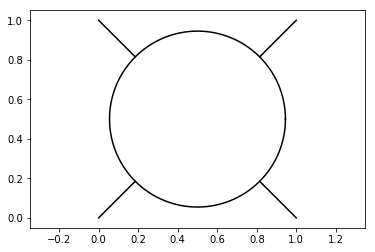

In [4]:
t = np.linspace(0,2*np.pi,1000)
fig, ax = plt.subplots()
ax.plot(curve.x(t),curve.y(t), c='k')
for i in range(4):
    ax.plot([corner_pts[i,0],curve.x(curve.anchor_attach_index_sort[i+1])], [corner_pts[i,1],curve.y(curve.anchor_attach_index_sort[i+1])],c='k')
ax.set_aspect("equal", adjustable="datalim")
plt.show()



In [5]:
def dF_complex(x,h):
    return np.imag(F(x + 1j*h))/h

In [6]:
def gaus_int_loop(t0, t1, seg_num, t_anchors, corner_pts, xs, ys, E, I, A):
    num_int = 0
    int_points = -0.9739065285171717, -0.8650633666889845, -0.6794095682990244, -0.4333953941292472, -0.1488743389816312, 0.1488743389816312, 0.4333953941292472, 0.6794095682990244, 0.8650633666889845, 0.9739065285171717
    weights = 0.0666713443086881, 0.1494513491505806, 0.2190863625159820, 0.2692667193099963, 0.2955242247147529, 0.2955242247147529, 0.2692667193099963, 0.2190863625159820, 0.1494513491505806, 0.0666713443086881
    m_array = np.zeros((len(weights), 15))
    p_array = np.zeros((len(weights), 15))
    dsdt = np.zeros((len(weights)))
    c1 = (t1-t0)/2
    c2 = (t1+t0)/2
    for i in range(seg_num+1):
        if i > 0:
            r_x = (corner_pts[i-1,0] - xs(t_anchors[i]))
            r_y = (corner_pts[i-1,1] - ys(t_anchors[i]))
        else:
            r_x = 0
            r_y = 0
        for j in range(len(weights)):
            m_array[j,i*3] = -(ys(t_anchors[i]) - ys(c1*int_points[j]+c2)) - r_y
            m_array[j,i*3+1] = (xs(t_anchors[i])- xs(c1*int_points[j]+c2)) + r_x
            m_array[j,i*3+2] = 1
    
            #Numerically find the derivative
            h = 1e-16
            xt = -np.imag(xs(c1*int_points[j]+c2 + 1j*h))/h
            yt = -np.imag(ys(c1*int_points[j]+c2 + 1j*h))/h
            dsdt[j] = sympy.sqrt(xt**2 + yt**2)
            p_array[j,i*3] = xt/sympy.sqrt(xt**2 + yt**2)
            p_array[j,i*3+1] = yt/sympy.sqrt(xt**2 + yt**2)

    for i in range(len(weights)):
        M_int = np.outer(m_array[i,:],m_array[i,:])
        P_int = np.outer(p_array[i,:],p_array[i,:])
        num_int += (M_int/(E*I) + P_int/(E*A))*weights[i]*dsdt[i]
    num_int *= c1
    return num_int

In [7]:
A = 0.
for i in range(curve.t_anchors.shape[0]-1):
    t0 = curve.t_anchors[curve.anchor_attach_index_map[i]]
    t1 = curve.t_anchors[curve.anchor_attach_index_map[i+1]]
    A_temp = gaus_int_loop(t0, t1, i, curve.t_anchors[curve.anchor_attach_index_map], corner_pts, curve.x, curve.y, E, I, Area)
    A += A_temp

## Strands

In [8]:
def gaus_int_strand(x_curve, y_curve, x_corner, y_corner, E, I, A):
    t0 = 0
    t1 = 1
    num_int = 0
    int_points = -0.9739065285171717, -0.8650633666889845, -0.6794095682990244, -0.4333953941292472, -0.1488743389816312, 0.1488743389816312, 0.4333953941292472, 0.6794095682990244, 0.8650633666889845, 0.9739065285171717
    weights = 0.0666713443086881, 0.1494513491505806, 0.2190863625159820, 0.2692667193099963, 0.2955242247147529, 0.2955242247147529, 0.2692667193099963, 0.2190863625159820, 0.1494513491505806, 0.0666713443086881
    m_array = np.zeros((len(weights), 3))
    p_array = np.zeros((len(weights), 3))
    dsdt = np.zeros((len(weights)))
    c1 = (t1-t0)/2
    c2 = (t1+t0)/2
    
    tss = sympy.symbols('tss')
    xss = (x_curve - x_corner)*tss
    yss = (y_curve - y_corner)*tss
    xss = lambdify(tss, xss)
    yss = lambdify(tss, yss) 
            
    r_x = (x_corner - x_curve)
    r_y = (y_corner - y_curve)
            
    for i in range(len(weights)):
        m_array[i,0] = yss(c1*int_points[i]+c2) + r_y
        m_array[i,1] = -xss(c1*int_points[i]+c2) - r_x
        m_array[i,2] = -1
        #Numerically find the derivative
        h = 1e-16
        xt = np.imag(xss(c1*int_points[i]+c2 + 1j*h))/h
        yt = np.imag(yss(c1*int_points[i]+c2 + 1j*h))/h       
        dsdt[i] = sympy.sqrt(xt**2 + yt**2)
        p_array[i,0] = -xt/dsdt[i]
        p_array[i,1] = -yt/dsdt[i]
        p_array[i,:] /= np.linalg.norm(p_array[i,:])

    for i in range(len(weights)):
        M_int = np.outer(m_array[i,:],m_array[i,:])
        P_int = np.outer(p_array[i,:],p_array[i,:])
        num_int += (M_int/(E*I) + P_int/(E*A))*weights[i]*dsdt[i]
    num_int *= c1
    return num_int


In [9]:
int_strand = np.zeros((4,3,3))

for i in range(4):
    x_curve = np.array(curve.x(curve.t_anchors[i+1]))
    y_curve = np.array(curve.y(curve.t_anchors[i+1]))
    x_corner = corner_pts[curve.anchor_attach_index_map[i+1]-1,0]
    y_corner = corner_pts[curve.anchor_attach_index_map[i+1]-1,1]
    int_strand[i,:,:] = gaus_int_strand(x_curve, y_curve, x_corner, y_corner, E, I, Area)

In [10]:
A_star = np.zeros((15,15))
for i in range(4):
    A_star[(i+1)*3:(i+2)*3, (i+1)*3:(i+2)*3] = int_strand[i,:,:]

In [11]:
A_combined = np.zeros((18,18))
A_combined[:15,:15] = A + A_star

In [12]:
for i in range(1, curve.anchor_attach_index_sort.shape[0]-1):
    r_x = corner_pts[i-1,0] - curve.x(curve.t_anchors[i])
    r_y = corner_pts[i-1,1] - curve.y(curve.t_anchors[i])
    inp_array = np.eye(3)
    inp_array[0,2] = -(curve.y(curve.t_anchors[i])-curve.y(curve.t[0])) - r_y
    inp_array[1,2] = (curve.x(curve.t_anchors[i])-curve.x(curve.t[0])) + r_x
    A_combined[i*3:(i*3+3), 15:18] = inp_array
    A_combined[15:18, i*3:(i*3+3)] = np.transpose(inp_array)


In [13]:
ux = np.zeros((18,))
uy = np.zeros((18,))
uxy = np.zeros((18,))
u = np.zeros((18,5))
displacement = 0.01
for i in range(4):
    if i in np.array([0, 3]):
        ux[(i+1)*3] = displacement
    if i in np.array([0, 1]):
        uy[(i+1)*3+1] = displacement
    if i in np.array([0]):
        uxy[(i+1)*3] = displacement/2
    if i in np.array([1]):
        uxy[(i+1)*3] = displacement/2

u[:,0] = ux
u[:,1] = uy
u[:,2] = uxy

In [14]:
F_resultant_x = np.linalg.solve(A_combined,ux)
F_resultant_y = np.linalg.solve(A_combined,uy)
F_resultant_xy = np.linalg.solve(A_combined,uxy)
f = np.zeros((18,3))
f[:,0] = F_resultant_x
f[:,1] = F_resultant_y
f[:,2] = F_resultant_xy

#This solves for the additional moments at the corners from the forces at the loop
for i in range(4):
    x_curve = np.array(curve.x(curve.t_anchors[i+1]))
    y_curve = np.array(curve.y(curve.t_anchors[i+1]))
    x_corner = corner_pts[curve.anchor_attach_index_map[i+1]-1,0]
    y_corner = corner_pts[curve.anchor_attach_index_map[i+1]-1,1]
    x_vec = x_curve - x_corner
    y_vec = y_curve - y_corner
    f[(i+1)*3+2,:] = x_vec*f[(i+1)*3+1,:] - y_vec * f[(i+1)*3,:] - f[(i+1)*3+2,:]


In [15]:
F_CE = f[[3, 4, 6, 7, 9, 10, 12, 13],:]
u_ce = u[[3, 4, 6, 7, 9, 10, 12, 13],:]

In [16]:
sigma = np.zeros((3,3))
sigma[0,0] = F_CE[0,0] + F_CE[6,0]
sigma[1,0] = F_CE[1,0] + F_CE[3,0]
sigma[2,0] = 0

sigma[0,1] = F_CE[0,1] + F_CE[6,1]
sigma[1,1] = F_CE[1,1] + F_CE[3,1]
sigma[2,1] = 0

sigma[0,2] = 0
sigma[1,2] = 0
sigma[2,2] = (F_CE[0,2] + F_CE[1,2] + F_CE[2,2] + F_CE[7,2])/2

eps = np.zeros((3,3))
eps[0,0] = displacement
eps[1,1] = displacement
eps[2,2] = displacement

In [17]:
def obj_func(C,f,u):
    error = 0
    nx = 4
    ny = nx
    for i in range(3):
        error += cp.sum_squares(f[:,i]-C@u[:,i])
    return error

# Construct the problem.
C = cp.Variable((3,3), PSD=True)
E_min = 0
E_max = 300000
nu_min = -1
nu_max = 0.5
c11_max = E_max/(.75)
c12_max = c11_max*0.5
constraints = [C[0,0] == C[1,1], C[0,2] == 0, C[1,2] == 0]
prob = cp.Problem(cp.Minimize(obj_func(C,sigma,eps)), constraints)
# Solve the optimization problem
result = prob.solve()

In [18]:
nu_calc = C.value[1,0]/C.value[0,0]
E_calc = C.value[0,0]*(1-nu_calc**2)
G_calc = C.value[2,2]/C.value[0,0]

In [19]:
print('E =', E_calc)
print('nu =', nu_calc)
print('G =', G_calc)

E = 10935.607417058069
nu = 0.18314637000048462
G = 0.04210712717827624
